# LAB 2 -  Grangier-Roger-Aspect experiment

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.optimize import curve_fit

### Data loading

In [2]:
def load_data_malus_law(path):
  angle = []
  transmitted = []
  
  with open(path, 'r') as file:
    next(file)
    
    for line in file:
      columns = line.split(",")
      angle.append(int(columns[0]))
      transmitted.append(int(columns[1]))
  
  transmitted = np.array(transmitted) - min(transmitted)

  return np.array(angle), np.array(transmitted)


def load_data(path):
  data = []
  
  with open(path, 'r') as file:
    for _ in range(5):
      next(file)

    for line in file:
      columns = line.split(";")
      data.append([int(columns[0]), int(columns[1])])
      
  data = np.array(data)
  data[:, 0] = data[:, 0] - data[0, 0]
    
  return data

In [3]:
angles, transmitted_photons = load_data_malus_law("Data/half-wave plate.csv")
set1 = load_data("Data/GRA/set1.txt")
set2 = load_data("Data/GRA/set2.txt")
set3 = load_data("Data/GRA/set3.txt")

### Malus law

In [4]:
def malus_function(x, a, b, c):
  x = x/90*np.pi
  return a * np.cos(b*x + c) ** 2

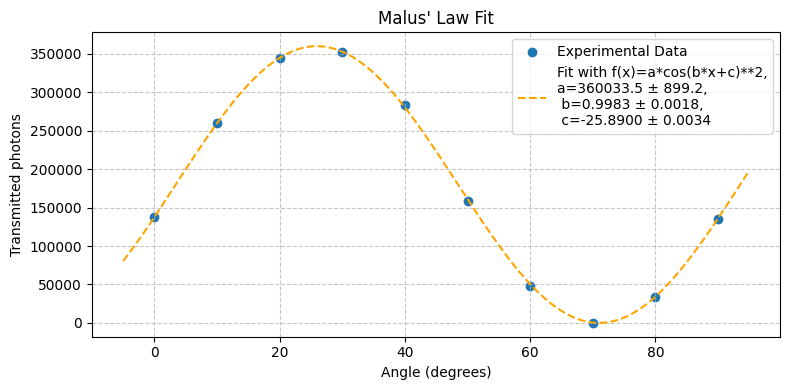

In [5]:
plt.figure(figsize=(8, 4))

plt.scatter(angles, transmitted_photons, label='Experimental Data')

popt_coherent_static, pcov_static = curve_fit(malus_function, angles, transmitted_photons, p0=[45000.0, 1.0, 90.0])

x_angles = np.arange(min(angles)-5, max(angles)+5, 0.1)
plt.plot(x_angles, malus_function(x_angles, *popt_coherent_static), color='orange', linestyle='--',
         label=f'Fit with f(x)=a*cos(b*x+c)**2,\n'
               f'a={popt_coherent_static[0]:.1f} ± {np.sqrt(pcov_static[0][0]):.1f},\n '
               f'b={popt_coherent_static[1]:.4f} ± {np.sqrt(pcov_static[1][1]):.4f},\n '
               f'c={popt_coherent_static[2]/np.pi*90 - 7.25*360:.4f} ± {np.sqrt(pcov_static[2][2]):.4f}')

plt.xlabel('Angle (degrees)')
plt.ylabel('Transmitted photons')
plt.title('Malus\' Law Fit')
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### GRA Experiment

In [6]:
set1[set1[:,1] == 2][:,0]

array([          0,       67323,       96484, ..., 55724227238,
       55725434828, 55725636977])

In [7]:
set1_heralded = set1[set1[:, 1] == 1]
set1_transmitted = set1[set1[:, 1] == 2]
set1_reflected = set1[set1[:, 1] == 3]

set2_heralded = set2[set2[:, 1] == 1]
set2_transmitted = set2[set2[:, 1] == 2]
set2_reflected = set2[set2[:, 1] == 3]

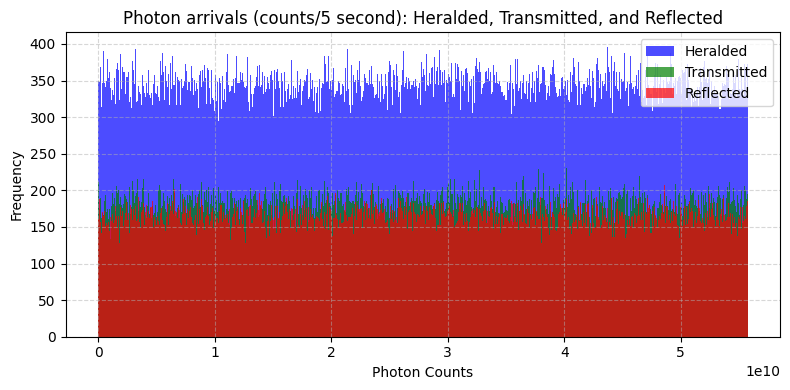

In [8]:
plt.figure(figsize=(8, 4))

plt.hist(set1_heralded[:, 0], bins=1000, color='blue', alpha=0.7, label='Heralded')
plt.hist(set1_transmitted[:, 0], bins=1000, color='green', alpha=0.7, label='Transmitted')
plt.hist(set1_reflected[:, 0], bins=1000, color='red', alpha=0.7, label='Reflected')

plt.xlabel('Photon Counts')
plt.ylabel('Frequency')
plt.title('Photon arrivals (counts/5 second): Heralded, Transmitted, and Reflected')
plt.legend(loc='upper right')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
def time_differences_between_channels(data, channel_a, channel_b = 1):
  channel_a_times = data[data[:, 1] == channel_a][:, 0]
  channel_b_times = data[data[:, 1] == channel_b][:, 0]
  time_differences = []
  
  for t_a in channel_a_times:
    nearest_t_b = channel_b_times[np.abs(channel_b_times - t_a).argmin()]
    time_differences.append(t_a - nearest_t_b)
  
  return np.array(time_differences)

In [10]:
t_diff_31 = time_differences_between_channels(set1, 3, 1)
t_diff_21 = time_differences_between_channels(set1, 2, 1)

In [17]:
print(len(t_diff_21))
print(len(t_diff_21[t_diff_21 > 0]))
print(len(t_diff_21[t_diff_21 < 1000]))

184825
88117
101019


In [11]:
def counter(data, threshold):
  counts = []
  total_time = 0
  count = 0

  for time in data:
    total_time += time

    if np.abs(total_time) <= threshold:
      count += 1
    else:
      counts.append(count)
      total_time = 0
      count = 0

  if count > 0:
    counts.append(count)
 
  return np.array(counts)

In [14]:
deltaT = 10e6 / 81
count_21 = counter(t_diff_21, deltaT)
count_31 = counter(t_diff_31, deltaT)

print(min(count_21))
print(len(count_21))

0
47931


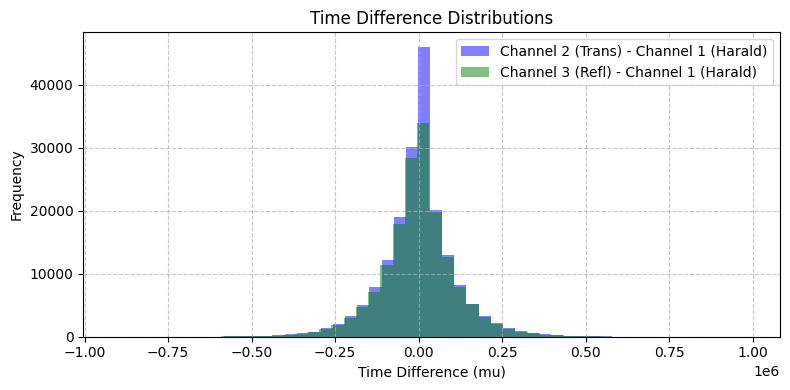

In [22]:
plt.figure(figsize=(8, 4))

plt.hist(t_diff_21, bins=50, color='blue', alpha=0.5, label='Channel 2 (Trans) - Channel 1 (Harald)')
plt.hist(t_diff_31, bins=50, color='green', alpha=0.5, label='Channel 3 (Refl) - Channel 1 (Harald)')

plt.xlabel('Time Difference (mu)')
plt.ylabel('Frequency')
plt.title('Time Difference Distributions')
plt.legend(loc='upper right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Quantum Random Number Generator

In [ ]:
def bits_to_byte(bits):
  byte = 0
  for bit in bits:
    byte = (byte << 1) | bit
  return byte
  
def qrng_list(data, channel_a, channel_b):
  bits_list = []
  bytes_list = []

  for i in range(0, len(data)):
    if data[i, 1] == channel_a:
      bits_list.append(1)
    elif data[i, 2] == channel_b:
      bits_list.append(1)

  bits_list = np.array(bits_list)
  
  for i in range(0, len(bits_list), 8):
    byte_chunk = bits_list[i:i+8]
    if len(byte_chunk) == 8:
      bytes_list.append(bits_to_byte(byte_chunk))
  
  return bytes_list

In [ ]:
bytes_list = qrng_list(static)

with open("random/data/qrng.bin", "wb") as file:
  file.write(bytearray(bytes_list))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

counts_qrng, bin_edges_qrng, _ = ax1.hist(bytes_list, bins=max(bytes_list)+1)
mean_qrng = np.mean(counts_qrng)
std_qrng = np.std(counts_qrng)

ax1.axhline(y=mean_qrng, color='r')
ax1.axhline(y=mean_qrng - std_qrng, color='b')
ax1.axhline(y=mean_qrng + std_qrng, color='b')
ax1.set_xlabel("Numbers")
ax1.set_ylabel("Times")
ax1.set_title("Histogram of numbers frequency")

ax2.hist(counts_qrng, bins=20)
ax2.set_xlabel("Number of occurrences")
ax2.set_ylabel("Times")
ax2.set_title("Histogram of occurrences frequency")

plt.show()

print(f'Bytes:\nMean: {np.mean(bytes_list)}, Standard Deviation: {np.std(bytes_list)}\n')
print(f'Counts:\nMean: {mean_qrng}, Standard Deviation: {std_qrng}')

In [ ]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
color_choices = []

x_vals = []
y_vals = []
z_vals = []

k = 0
while k < len(bytes_list) - 2:
  x_vals.append(bytes_list[k])
  y_vals.append(bytes_list[k+1])
  z_vals.append(bytes_list[k+2])
  color_choices.append(random.choice(colors))
  k += 3

fig = go.Figure(data=[go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers', marker=dict(size=2, color=color_choices, opacity=0.6))])

fig.update_layout(
  title="Interactive 3D Scatter Plot - QRNG",
  scene=dict(
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    zaxis_title='Z Axis'
  ),
  width=1000, height=1000
)

fig.show()